In [1]:
import numpy as np
import pandas as pd

# cross validation purposes: create the cartesian product between the chosen values sets
from itertools import product 

#import os
#import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Read Dataset

In [2]:
cmp = pd.read_csv("commViolUnnormData.txt", na_values='?')

In [3]:
# drop first non predictive features (communityname, state, countyCode, communityCode, "fold")
pred_features = cmp[cmp.columns[5:-18]]
regr_values = cmp[cmp.columns[-18:]]

# Drop features with a lot of missing values

In [4]:
print("Before dropping: {} features".format(str(pred_features.shape[1])))

#drop features that contain at least some threshold (from the total) of NaN values
cut_tresh = 0.75
to_drop = pred_features.columns[pred_features.count() < pred_features.shape[0]*cut_tresh]

pred_features = pred_features.drop(columns=to_drop)

print("After dropping: {} features".format(str(pred_features.shape[1])))

Before dropping: 124 features
After dropping: 102 features


# Imputing on features matrix

In [5]:
from collections import Counter

def value_withStrategy(v, strat):
    if strat == "mean":
        return np.mean(v)
    if strat == "median":
        return np.median(v)
    if strat == "most_frequent":
        return Counter(v).most_common(1)[0][0]
    print("Invalid imputing strategy!")
        
def imputing(df, strategy):
    # for each column that contain at least 1 NaN value...
    for nanCol in np.unique(np.where(pred_features.isna())[1]):
        nanRows = np.where(pred_features.iloc[:,nanCol].isna())[0] #find NaN rows for the current column
        available = df.iloc[~nanRows, nanCol]
        value = value_withStrategy(available, strategy) #compute the filling value
        df.iloc[nanRows, nanCol] = value

In [6]:
imputing(pred_features, "mean");

# Outliers Detection

-- TBD <br>
A thourough study from scratch of outliers detection is needed here, but for now it feels like it exceeds the course final project.

# Choose the Dependent Variable and drop possible missing values rows on it

In [7]:
def drop_naSample(df, vals):
    idxRow = np.where(vals.isna())[0]
    return df.drop(index=idxRow).values, vals.drop(index=idxRow).values.reshape(-1,1)

In [8]:
dep_var = "robbPerPop"
data,values = drop_naSample(pred_features, regr_values[dep_var])

# Normalisation

In [9]:
def normalise(matrix, strat):
    for j in range(matrix.shape[1]):
        mi = np.min(matrix[:,j])
        ma = np.max(matrix[:,j])
        di = ma-mi
        if (di > 1e-6):
            if strat=="0_mean,1_std":
                matrix[:,j] = (matrix[:,j]-np.mean(matrix[:,j]))/np.std(matrix[:,j])
            elif strat=="[0,1]":
                matrix[:,j] = (matrix[:,j]-mi)/di
            elif strat=="[-1,1]":
                matrix[:,j] = 2*((matrix[:,j]-mi)/di)-1
            else:
                print("Invalid normalisation strategy!")
        else:
            matrix[:,j] = 0

In [10]:
strategy = "[-1,1]"
normalise(data,strategy)
normalise(values,strategy)

# Train-Test Split

In [11]:
def trainTest_split(in_matrix, out_vect, train_amount=0.7):
    n,_ = in_matrix.shape

    trVl_Amount = int(n*train_amount) #training-validation amount
    indexes = np.random.permutation(n)
    idxTrVl = np.sort(indexes[0:trVl_Amount])
    idxTs = np.sort(indexes[trVl_Amount:])

    return in_matrix[idxTrVl], in_matrix[idxTs], out_vect[idxTrVl], out_vect[idxTs]

In [12]:
trainVal_data, test_data, trainVal_values, test_values = trainTest_split(data, values, train_amount=0.7)

# Evaluation Metrics

In [13]:
class Regression_evaluationMetric:
    def __init__(self, true, predicted):
        self.true = true.flatten()
        self.predicted = predicted.flatten()
        self.residuals = self.true-self.predicted
    
    def meanSquareError(self):
        return np.mean(np.square(self.residuals))
    
    def rootMeanSquareError(self):
        return np.sqrt(np.mean(np.square(self.residuals)))
    
    def meanAbsoluteError(self):
        return np.mean(np.abs(self.residuals))
    
    def rSquared(self):
        ss_residual = np.sum(np.square(self.residuals))
        ss_total = np.sum(np.square(self.true-np.mean(self.true)))        
        return 1 - ss_residual/ss_total
    
    def adjusted_rSquared(self, p):
        n = self.true.shape[0]
        return 1-(1-self.rSquared)*((n-1)/(n-p-1))


# Variable Selection - Models Definition

## 0. K-fold Cross Validation

In [14]:
from itertools import product

def kFold_crossValidation_selectionGrid(k, parameters_dict, train_data, train_values, predictor, verbose=False):
    nVal,_ = train_data.shape
    
    # Validation indexes adjustment -------------------------------
    elemPerFold, remainder = np.divmod(nVal,k) #the remainder will be distributed across the firsts folds
    valIdxList = []
    start = 0

    # in each fold put as many samples as the division quotient +1 if the remainder is still positive
    # then decrease the division remainder by 1
    for i in range(k): 
        end = start+elemPerFold+int(remainder>0)
        valIdxList.append(np.arange(start,end)) 
        remainder -= 1
        start = end
    
    # Cross validation --------------------------------------------
    params_names = parameters_dict.keys()
    params_product = list(product(*parameters_dict.values())) # build all the hyp-par combination
    val_results = np.empty((len(valIdxList),len(params_product)))
    
    for row, valIdx in enumerate(valIdxList): # for each fold
        if verbose: print("#{} fold:".format(row+1))
        for col, params in enumerate(params_product):
            
            if verbose:
                update = col*100/len(params_product) # just print completion rate
                print("\t["+"#"*(int(update/5))+" "*(int((100-update)/5))+"] {}%".format(update))
                     
            arg_dict = {k:v for k,v in zip(params_names,params)} # {argument_name:argument_value, ... }
            
            
            predictor.fit(train_data[~valIdx], train_values[~valIdx], **arg_dict)
            pred = predictor.predict(train_data[valIdx])
            
            rem = Regression_evaluationMetric(trainVal_values[valIdx], pred)
            #val_results[row,col] = rem.rSquared()
            val_results[row,col] = rem.rootMeanSquareError()
            
    selected = np.argmin(val_results.mean(axis=0))
    return params_product[selected]

## 1. Matching Pursuit - Not Working (use the sklearn model)

### Project class definition

In [15]:
class matchingPursuit:
    def __init__(self, iterations, weights = None, indexes = None):
        self.iterations = iterations
        self.weights = weights
        self.indexes = indexes
        
    def fit(self, data_matrix, output_vect):
        residual = output_vect.copy()
        self.weights = np.zeros((data_matrix.shape[1], 1))
        self.indexes = []

        #data_2norm = np.sqrt(np.sum(np.square(data_matrix), axis=0))
        data_2norm = np.linalg.norm(data_matrix, ord=2, axis=0).reshape(1,-1)

        for i in range(self.iterations):
            
            # project each column on the current residuals
            projection = np.matmul(residual.T, data_matrix)
            # find the most correlated variable: the one that in norm maximise the projections
            k = np.argmax(np.divide(np.square(projection), data_2norm))
            self.indexes.append(k)
            
            distance = projection[0,k]/np.linalg.norm(data_matrix[:,k], ord=2)
            self.weights[k,0] += distance # update the solution vector: canonical basis over the found column
            residual -= np.matmul(data_matrix, self.weights) # update the residual

        return self
    
    
    def predict(self, X):
        if self.weights is None:
            raise Exception("weights not initialised! need to first fit the model")
        return np.matmul(X, self.weights)
    
    
    def sort_featureImportances(self, columns=None, num=0):
        if self.weights is None:
            raise Exception("Need to first fit the model!")
            
        d = len(self.weights)
        n_printFeat = d if not num else num
        
        if columns is None:
            return sorted(zip(range(d),self.weights), key=lambda kv: abs(kv[1]), reverse=True)[:n_printFeat]

        if len(columns) != d:
            raise Exception("Argument list lenght differs from feature total amount")
        return sorted(zip(columns, self.weights), key=lambda kv: abs(kv[1]), reverse=True)[:n_printFeat]

In [16]:
mp = matchingPursuit(iterations=10)
mp.fit(trainVal_data, trainVal_values)
mp.sort_featureImportances(columns=pred_features.columns)

[('NumStreet', array([-4.63668685e+15])),
 ('NumKidsBornNeverMar', array([33.83809382])),
 ('population', array([0.])),
 ('householdsize', array([0.])),
 ('racepctblack', array([0.])),
 ('racePctWhite', array([0.])),
 ('racePctAsian', array([0.])),
 ('racePctHisp', array([0.])),
 ('agePct12t21', array([0.])),
 ('agePct12t29', array([0.])),
 ('agePct16t24', array([0.])),
 ('agePct65up', array([0.])),
 ('numbUrban', array([0.])),
 ('pctUrban', array([0.])),
 ('medIncome', array([0.])),
 ('pctWWage', array([0.])),
 ('pctWFarmSelf', array([0.])),
 ('pctWInvInc', array([0.])),
 ('pctWSocSec', array([0.])),
 ('pctWPubAsst', array([0.])),
 ('pctWRetire', array([0.])),
 ('medFamInc', array([0.])),
 ('perCapInc', array([0.])),
 ('whitePerCap', array([0.])),
 ('blackPerCap', array([0.])),
 ('indianPerCap', array([0.])),
 ('AsianPerCap', array([0.])),
 ('OtherPerCap', array([0.])),
 ('HispPerCap', array([0.])),
 ('NumUnderPov', array([0.])),
 ('PctPopUnderPov', array([0.])),
 ('PctLess9thGrade', 

In [17]:
pred = mp.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

Residual variance: 1.3270881403795465e+29
Root Mean Square Error: 4627754785715472.0
R^2 score: -5.041673456511588e+32


### SkLearn Class

In [18]:
from sklearn.linear_model import orthogonal_mp
omp_coef = orthogonal_mp(trainVal_data, trainVal_values)
np.where(omp_coef)[0]

array([ 3, 11, 34, 38, 50, 76, 77, 92, 93, 94])

In [19]:
pred = np.matmul(test_data, omp_coef)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

Residual variance: 0.07716713048922287
Root Mean Square Error: 0.11125529597117739
R^2 score: 0.7086094768869478


## 2. L1 Penalty (Lasso) with Proximal Gradient - Not Working (use the sklearn model)

### Project class definition

In [20]:
class lasso_regression: # Iterative Soft Thresholding Algorithm
    def __init__(self, iterations, weights=None):
        self.iterations = iterations
        self.weights = weights
        
    def fit(self, data_matrix, output_vect, _lambda):
        n,d = data_matrix.shape
        self.weights = np.zeros((d,1))
        
        # convergence step-size: n/(2*||X^t*X||_2)
        step = n/(2*np.linalg.norm(np.matmul(data_matrix.T, data_matrix), ord=2))
        softTresh = step*_lambda

        for i in range(self.iterations):
            # gradient step of the mse formulation
            resid = np.matmul(data_matrix, self.weights) - output_vect
            grad_descent = (step/n)*np.matmul(data_matrix.T, resid)
            self.weights -= 2*grad_descent

            # proximal operator
            upper = self.weights > softTresh  # elem to be reduced
            lower = self.weights < -softTresh # elem to be increased
            self.weights[upper] -= softTresh
            self.weights[lower] += softTresh
            self.weights[~upper & ~lower] = 0

        return self
    
    def predict(self, X):
        if self.weights is None:
            raise Exception("weights not initialised! need to first fit the model")
        return np.matmul(X, self.weights)
    
    def sort_featureImportances(self, columns=None, num=0):
        if self.weights is None:
            raise Exception("Need to first fit the model!")
            
        d = len(self.weights)
        n_printFeat = d if not num else num
        
        if columns is None:
            return sorted(zip(range(d),self.weights), key=lambda kv: abs(kv[1]), reverse=True)[:n_printFeat]

        if len(columns) != d:
            raise Exception("Argument list lenght differs from feature total amount")
        return sorted(zip(columns, self.weights), key=lambda kv: abs(kv[1]), reverse=True)[:n_printFeat]

In [21]:
lr = lasso_regression(iterations=1000)
lr.fit(trainVal_data, trainVal_values, 0.5)
lr.sort_featureImportances(columns=pred_features.columns)

[('NumKidsBornNeverMar', array([0.10104377])),
 ('NumInShelters', array([0.0860739])),
 ('NumStreet', array([0.08195012])),
 ('NumUnderPov', array([0.08004374])),
 ('NumImmig', array([0.07533265])),
 ('population', array([0.06335219])),
 ('numbUrban', array([0.0583407])),
 ('HousVacant', array([0.05659798])),
 ('LemasPctOfficDrugUn', array([0.00699548])),
 ('LandArea', array([0.00181962])),
 ('householdsize', array([0.])),
 ('racepctblack', array([0.])),
 ('racePctWhite', array([0.])),
 ('racePctAsian', array([0.])),
 ('racePctHisp', array([0.])),
 ('agePct12t21', array([0.])),
 ('agePct12t29', array([0.])),
 ('agePct16t24', array([0.])),
 ('agePct65up', array([0.])),
 ('pctUrban', array([0.])),
 ('medIncome', array([0.])),
 ('pctWWage', array([0.])),
 ('pctWFarmSelf', array([0.])),
 ('pctWInvInc', array([0.])),
 ('pctWSocSec', array([0.])),
 ('pctWPubAsst', array([0.])),
 ('pctWRetire', array([0.])),
 ('medFamInc', array([0.])),
 ('perCapInc', array([0.])),
 ('whitePerCap', array([0.]

In [22]:
pred = lr.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

Residual variance: 0.038974246789447275
Root Mean Square Error: 0.3192202001848008
R^2 score: -1.3989144889238103


### SkLearn Class

In [23]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.005)
lasso.fit(trainVal_data, trainVal_values)
np.where(lasso.coef_)[0]

array([  3,  11,  38,  44,  50,  69,  76,  93,  94, 100])

In [24]:
pred = lasso.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

Residual variance: 0.06700266663502594
Root Mean Square Error: 0.11398320430750422
R^2 score: 0.6941448766218346


## 3. Random Forest

### Project Decision Tree class definition

In [25]:
class NumericalDecisionTree_regressor: # Least Square Regression Tree with either fixed parameter or pruning
    class Node:
        def __init__(self, isLeaf=False, feature=None, feature_importance=None, cut=None, average=None,
                     left=None, right=None):
            self.isLeaf = isLeaf
            self.feature = feature # if internal, on wich feature it executes the split
            self.feature_importance = feature_importance # solution variance reduction
            self.cut = cut # if internal, threahold value for the cut
            self.avg = average # mean of seen training values
            self.left = left
            self.right = right

        def print_tree(self):
            if self.left: self.left.print_tree()
            if self.cut:
                print("Feature: {}, cut: {}\n".format(self.feature, self.cut))
            else:
                print("Leaf => {}\n".format(self.avg))
            if self.right: self.right.print_tree()

        def print_tree_indented(self, level=0):
            if self.right: self.right.print_tree_indented(level+1)
            if self.cut:
                print("|    "*level+"{} => {}".format(self.feature, self.cut))
            else:
                print("|    "*level+"Leaf: {}".format(self.avg))                
            if self.left: self.left.print_tree_indented(level+1)
            
    def __init__(self, root=None, feature_importances=None):
        self.root = root
        self.feature_importances = feature_importances

        
    def fit(self, X, y, depth, minElems_perLeaf, post_pruning=False):
        
        self.feature_importances = {k:0 for k in range(X.shape[1])}
        
        if not post_pruning:
            self.root = self.learn(X, y.flatten(), depth, minElems_perLeaf)
        else:
            # train dataset, pruning dataset
            X_trn, X_val, y_trn, y_val = trainTest_split(X, y.flatten(), train_amount=0.7)
            self.root = self.learn(X_trn, y_trn, depth, minElems_perLeaf)
            self.prune(X_val, y_val)
        
        return self
        
    def learn(self, X, y, depth, minElems_perLeaf):
        n, d = X.shape

        if depth==0 or n<=minElems_perLeaf: # leaf # or fraction error of the root node??? 
            return self.Node(isLeaf=True, average=np.mean(y))
            
        best_costDescent = 0 # split that maximise the error descent

        for i1 in range(d):
            sorted_idx = np.argsort(X[:,i1])
            sorted_x, sorted_y = X[sorted_idx, i1], y[sorted_idx]

            s_right, s_left = np.sum(sorted_y), 0
            n_right, n_left = n, 0

            for i2 in range(n-1):
                s_left += sorted_y[i2]
                s_right -= sorted_y[i2]
                n_left += 1
                n_right -= 1
                
                if sorted_x[i2]<sorted_x[i2+1]: # for a different value
                    # try to maximise this value: it is directly correlated 
                    # to the possible split information gain
                    new_costDescent = (s_left**2)/n_left + (s_right**2)/n_right
                    if new_costDescent > best_costDescent:
                        best_costDescent = new_costDescent
                        best_feature = i1
                        best_cut = (sorted_x[i2]+sorted_x[i2+1])/2
                        
        # update the importance for the selected feature
        feature_importance = np.var(y) - (np.sum(np.square(y))-best_costDescent)/n
        self.feature_importances[best_feature] += feature_importance

        left_idxs = X[:,best_feature] < best_cut
        
        return self.Node(feature=best_feature, feature_importance=feature_importance,
                         cut=best_cut, average=np.mean(y),
                         left = self.learn(X[left_idxs], y[left_idxs], depth-1, minElems_perLeaf),
                         right = self.learn(X[~left_idxs], y[~left_idxs], depth-1, minElems_perLeaf))
    
    def prune(self, X, y):
        # for statistics purposes check errors on different dataset portions and average them
        # in order to decide whether to prune or not (same code of k-fold cross-validation)
        n,_ = X.shape
        folds = 5
        elemPerFold, remainder = np.divmod(n, folds)
        foldsIdxsList = []
        start = 0
        for i in range(folds): 
            end = start+elemPerFold+int(remainder>0)
            foldsIdxsList.append(np.arange(start,end)) 
            remainder -= 1
            start = end
        
        # recursive: start checking if the root receive a possible positive pruning from its sons
        self.test_pruning(self.root, X, y, foldsIdxsList)
        return self
    
    def test_pruning(self, node, X, y, foldIdxs):
        if node.isLeaf: # leaf: start point of new possible pruning
            return True
        
        # check sons response: if one of them is negative to be pruned it means that it performs an important
        # predictive split
        if not self.test_pruning(node.left, X, y, foldIdxs) or not self.test_pruning(node.right, X, y, foldIdxs):
            return False
        
        # else proceed with testing the goodness of the current node split
        folds = len(foldIdxs)
        results = np.empty(folds)

        # not pruned errors on different folds
        for i, idxs in enumerate(foldIdxs):
            pred = self.predict(X[idxs])
            results[i] = Regression_evaluationMetric(true=y[idxs], predicted=pred).rootMeanSquareError()

        not_prunErr = np.mean(results)

        # pruned errors on different folds
        node.isLeaf = True
        for i, idxs in enumerate(foldIdxs):
            pred = self.predict(X[idxs])
            results[i] = Regression_evaluationMetric(true=y[idxs], predicted=pred).rootMeanSquareError()

        # if pruning improves the prediction RMSE then keep current node as leaf
        node.isLeaf = np.mean(results) <= not_prunErr
        
        if node.isLeaf:
            # lower feature importance computed during training phase
            self.feature_importances[node.feature] -= node.feature_importance 
            node.left = None
            node.right = None
            
        return node.isLeaf
            
    def predict(self, X):
        if self.root is None:
            raise Exception("Tree not initialised! need to first fit the model")

        n,_ = X.shape
        y = np.empty(n)
        
        for i in range(n):
            current = self.root
            while not current.isLeaf:
                if X[i,current.feature] < current.cut:
                    current = current.left
                else:
                    current = current.right
                
            y[i] = current.avg
        
        return y
                
    def pprint(self):
        self.root.print_tree_indented()
        
    def sort_featureImportances(self, columns=None, num=0):
        if self.feature_importances is None:
            raise Exception("Need to first fit the model!")
            
        d = len(self.feature_importances)
        n_printFeat = d if not num else num
        
        if columns is None:
            return sorted(self.feature_importances.items(), key=lambda kv: kv[1], reverse=True)[:n_printFeat]
            
        if len(columns) != d:
            raise Exception("Argument list lenght differs from feature total amount")
            
        return sorted(zip(map(lambda kv: round(kv[1], 4), self.feature_importances.items()), columns),
                      reverse=True)[:n_printFeat]

In [26]:
ndt = NumericalDecisionTree_regressor()
ndt.fit(trainVal_data, trainVal_values, depth=5, minElems_perLeaf=10)
ndt.pprint()

|    |    |    |    Leaf: 0.25373837485774514
|    |    |    51 => -0.8254687790308851
|    |    |    |    |    Leaf: -0.18807665637573817
|    |    |    |    2 => -0.5304644667425261
|    |    |    |    |    Leaf: -0.460075172362011
|    |    51 => -0.9862140053031551
|    |    |    |    |    Leaf: -0.7051040676671714
|    |    |    |    3 => 0.36348633316142354
|    |    |    |    |    Leaf: -0.48760381296684896
|    |    |    100 => -0.9688937971654703
|    |    |    |    |    Leaf: -0.6919543248199289
|    |    |    |    91 => -0.9989308471966813
|    |    |    |    |    Leaf: -0.8054220578776127
|    43 => -0.3406484496672801
|    |    |    Leaf: 0.5354368218382209
|    |    100 => -0.3436407141542426
|    |    |    Leaf: -0.15723147522447922
50 => -0.5616087751371115
|    |    |    |    |    Leaf: -0.6196401413935301
|    |    |    |    2 => -0.8772111306506672
|    |    |    |    |    Leaf: -0.7470893541249128
|    |    |    36 => -0.6580419580419581
|    |    |    |    Leaf: -0

In [27]:
pred = ndt.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

Residual variance: 0.08623683554319454
Root Mean Square Error: 0.13630140453127904
R^2 score: 0.5626443931984483


In [28]:
ndt.sort_featureImportances()

[(100, 0.1273753198453829),
 (51, 0.05250052214366452),
 (43, 0.03702410084615772),
 (2, 0.0227134476249547),
 (36, 0.022471731578918124),
 (50, 0.01975491645884912),
 (3, 0.011630659040595813),
 (93, 0.0029850474401389698),
 (91, 0.002925972197938116),
 (18, 0.002438949641839816),
 (11, 0.0018461869496656062),
 (49, 0.0011808882008847903),
 (99, 0.001145454390114091),
 (40, 0.0002518754355045176),
 (0, 0),
 (1, 0),
 (4, 0),
 (5, 0),
 (6, 0),
 (7, 0),
 (8, 0),
 (9, 0),
 (10, 0),
 (12, 0),
 (13, 0),
 (14, 0),
 (15, 0),
 (16, 0),
 (17, 0),
 (19, 0),
 (20, 0),
 (21, 0),
 (22, 0),
 (23, 0),
 (24, 0),
 (25, 0),
 (26, 0),
 (27, 0),
 (28, 0),
 (29, 0),
 (30, 0),
 (31, 0),
 (32, 0),
 (33, 0),
 (34, 0),
 (35, 0),
 (37, 0),
 (38, 0),
 (39, 0),
 (41, 0),
 (42, 0),
 (44, 0),
 (45, 0),
 (46, 0),
 (47, 0),
 (48, 0),
 (52, 0),
 (53, 0),
 (54, 0),
 (55, 0),
 (56, 0),
 (57, 0),
 (58, 0),
 (59, 0),
 (60, 0),
 (61, 0),
 (62, 0),
 (63, 0),
 (64, 0),
 (65, 0),
 (66, 0),
 (67, 0),
 (68, 0),
 (69, 0),
 (70, 

In [29]:
ndt = NumericalDecisionTree_regressor()
ndt.fit(trainVal_data, trainVal_values, depth=100, minElems_perLeaf=10, post_pruning=True)
ndt.pprint()

|    |    |    |    Leaf: 0.3911171178333399
|    |    |    36 => -0.25920745920745936
|    |    |    |    |    Leaf: -0.24302756467163994
|    |    |    |    32 => -0.6820461384152459
|    |    |    |    |    Leaf: -0.5804613692676657
|    |    49 => -0.9290143055631903
|    |    |    |    |    |    Leaf: -0.4705162689421543
|    |    |    |    |    72 => 0.8078985860555827
|    |    |    |    |    |    Leaf: -0.6811784953455264
|    |    |    |    49 => -0.9773086130977316
|    |    |    |    |    |    |    Leaf: -0.7606523098433898
|    |    |    |    |    |    100 => -0.9215902816123689
|    |    |    |    |    |    |    |    Leaf: -0.8620856576256664
|    |    |    |    |    |    |    6 => -0.6144118827780007
|    |    |    |    |    |    |    |    Leaf: -0.7932715877621869
|    |    |    |    |    3 => 0.5069623517276947
|    |    |    |    |    |    |    |    Leaf: -0.7167322547733567
|    |    |    |    |    |    |    15 => -0.28607473266850897
|    |    |    |    |    |    |  

In [30]:
pred = ndt.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

Residual variance: 0.0847536097367572
Root Mean Square Error: 0.13403475866886674
R^2 score: 0.5770695935516105


In [31]:
ndt.sort_featureImportances()

[(3, 0.06702521562253035),
 (100, 0.06412261027028934),
 (36, 0.06108907835644606),
 (49, 0.04547755072596042),
 (13, 0.02548077375491929),
 (94, 0.02416452845156344),
 (38, 0.019866649044650957),
 (32, 0.016564579887192003),
 (46, 0.016302005629638593),
 (98, 0.012522158583232646),
 (43, 0.01157343698456752),
 (72, 0.01096262448873916),
 (99, 0.009136088069872749),
 (4, 0.008880883383477027),
 (76, 0.007914468445432313),
 (37, 0.007637729770328492),
 (1, 0.007608964262434628),
 (54, 0.006684546017686161),
 (80, 0.006588530959434208),
 (50, 0.006186572357350506),
 (12, 0.006084909063030391),
 (0, 0.005515728487946607),
 (44, 0.005388847108452802),
 (81, 0.005320940794582167),
 (25, 0.004831572634684013),
 (6, 0.004740577343937272),
 (15, 0.004703170319397627),
 (40, 0.004396891676440733),
 (8, 0.004216425276131762),
 (35, 0.0037306561184097505),
 (28, 0.0031286369597798096),
 (18, 0.003096145019872206),
 (34, 0.002982834881994128),
 (73, 0.002226541420462243),
 (26, 0.00199992598627987

### Decision Tree SkLearn Class

In [32]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()
dtr.fit(trainVal_data, trainVal_values)
np.flip(np.argsort(dtr.feature_importances_))

array([ 50,  51,  43, 100,  36,   2,   3,  93,  11,  44,  27,  58,  94,
        49,  99,  18,  61,  91,  41,  40,  74,  46,  30,  25,  60,   8,
        65,  20,   9,  77,  13,  88,   4, 101,  95,  62,  47,  21,  68,
        98,  73,  15,  33,  22,  89,  63,  26,  16,  85,  90,  23,  14,
        28,  69,  38,  45,  71,  81,  12,   6,  32,  76,  67,  92,   5,
        31,  57,  48,  86,  87,  72,  78,  52,  59,  96,  37,  75,  42,
        83,  55,  35,  97,  53,  56,  82,  54,   0,   7,  17,  19,  79,
        10,  70,   1,  39,  66,  24,  64,  34,  29,  84,  80])

In [33]:
pred = dtr.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

Residual variance: 0.09497097426128245
Root Mean Square Error: 0.14954065239741324
R^2 score: 0.4735555175731505


### Project Random Forest class definition

In [34]:
class NumericalRandomForest_regressor: # post-pruning (kinda) with cross-validation or greedy 
    def __init__(self, n_trees, trees=None, bootstrap_subSpace=None, outOfBag_error=None, feat_importances=None):
        self.n_trees = n_trees
        self.trees = trees
        self.bootSamplesIdxs_SubSp = bootstrap_subSpace
        self.oob_error = outOfBag_error
        self.feature_importances = feat_importances
        
    def fit(self, X, y, depth, minElems_perLeaf, post_pruning=True, verbose=False):
        n,d = X.shape
        
        self.trees = []
        self.bootSamplesIdxs_SubSp = []
        self.feature_importances = {k:0 for k in range(d)}
        
        n_learn = int(n/3) # Bootstrap amount to be taken aside
        # random subspace method amount
        d_learn = int(d/self.n_trees) if int(d/self.n_trees) >= int(np.sqrt(d)) else int(np.sqrt(d))
                
        # Fitting the forest -----------------------------------
        for i in range(self.n_trees):
            if verbose: print("\tFitting #{} tree".format(i+1))
            
            bootstrap_idxs = np.sort(np.random.permutation(n)[:n_learn])
            subspace_idxs = np.sort(np.random.permutation(d)[:d_learn])
            self.bootSamplesIdxs_SubSp.append((bootstrap_idxs, subspace_idxs))
                        
            dt = NumericalDecisionTree_regressor()
            
            self.trees.append(dt.fit(X[~bootstrap_idxs][:,subspace_idxs], y[~bootstrap_idxs],
                                     depth=depth, minElems_perLeaf=minElems_perLeaf, post_pruning=post_pruning))
            
            for k,v in dt.feature_importances.items():
                self.feature_importances[subspace_idxs[k]] += v
        
        # Out-Of-Bag Estimate for the forest -------------------
        oob_errors = []
        for sampleIdx in range(n):
            # finds all the tree that not have current sample in their bootstrapp set (not trained on it)
            # and the relative subspace on wich they have been trained
            missingTreesIdx_subspc = [(idx,subspace_idxs) for idx,(bootstrap_idxs,subspace_idxs)
                                      in enumerate(self.bootSamplesIdxs_SubSp)
                                      if sampleIdx not in bootstrap_idxs]

            if len(missingTreesIdx_subspc) == 0: continue
            
            regr_results = np.empty(len(missingTreesIdx_subspc)) # regression estimate of the selected trees
            for i, (missingTree_idx, tree_subSpace) in enumerate(missingTreesIdx_subspc):
                # reshape in order to correctly use the decision_tree.predict(...): it needs a matrix (num,dim)
                # while numpy matrix indexing returns (dim,)
                regr_results[i] = self.trees[missingTree_idx].predict(X[sampleIdx,tree_subSpace].reshape(1,-1))
            
            # done at this level of granularity because a sample might end up in 
            # being part of no bootstrap set of any tree (so we cannot predict wich value in y will be used)
            oob_errors.append(np.square(y[sampleIdx]-np.mean(regr_results)))
            #oob_errors.append(r2_score(np.mean(regr_results),y[sampleIdx]))
            #oob_errors.append(explained_variance_score(np.mean(regr_results),y[sampleIdx]))
            
        self.oob_error = np.sqrt(np.mean(oob_errors))
        return self
            
        
    def predict(self,X):
        if len(self.trees)==0:
            raise Exception("Trees not initialised! need to first fit the model")

        n,_ = X.shape
        results = np.empty((self.n_trees,n))
        for row, (tree,(_,subspace_idxs)) in enumerate(zip(self.trees, self.bootSamplesIdxs_SubSp)):
            results[row] = tree.predict(X[:,subspace_idxs])
            
        return np.mean(results,axis=0)
    
    def sort_featureImportances(self, columns=None, num=0):
        if self.feature_importances is None:
            raise Exception("Need to first fit the model!")
            
        d = len(self.feature_importances)
        n_printFeat = d if not num else num
        
        if columns is None:
            return sorted(self.feature_importances.items(), key=lambda kv: kv[1], reverse=True)[:n_printFeat]

        if len(columns) != d:
            raise Exception("Argument list lenght differs from feature total amount")
        return sorted(zip(columns, map(lambda kv: round(kv[1], 4), self.feature_importances.items())),
                      key=lambda kv: kv[1], reverse=True)[:n_printFeat]

In [35]:
n_trees = [1,10,20,30,50,70,100,150,200]
oob_errors = np.empty(len(n_trees))
for i, num_t in enumerate(n_trees):
    print("Training {} trees".format(num_t))
    nrf = NumericalRandomForest_regressor(num_t)
    # no train and test, cause it's a forest
    nrf.fit(data, values, depth=100, minElems_perLeaf=5);
    oob_errors[i] = nrf.oob_error

Training 1 trees
Training 10 trees
Training 20 trees
Training 30 trees
Training 50 trees
Training 70 trees
Training 100 trees
Training 150 trees
Training 200 trees


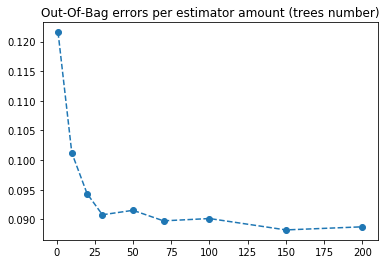

In [36]:
plt.title("Out-Of-Bag errors per estimator amount (trees number)")
plt.errorbar(n_trees, oob_errors, fmt='--o');

### Random Forest SkLearn class

In [37]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=100)
# oob error not working, need to perform evaluation on test split
rfr.fit(trainVal_data, trainVal_values.ravel())
np.flip(np.argsort(rfr.feature_importances_))

array([ 50,  49,   3, 100,  51,  43,  44,  99,   2,  91,  69,  41,  40,
        46,  92,  68,  93,  38,  66,  65,  45,  73,  82,  71,  59,  11,
        15,   1,   4,  88,  26,  10,  36,  29,   6,  74,  14,  78,  62,
         9,  94,  89,  17,   0,  77,  24,  18,  98,  32,   8,  30,  28,
        96,  25,  86,  34,  23,  21,  35,  80,  81,   5,  60,  72,  39,
        75,  27,  67,  57,  61,  22,  33,  97,   7,  58,  53,  16,  37,
        76,  47,  48,  95,  12,  90,  63,  19, 101,  79,  42,  20,  55,
        31,  64,  87,  52,  56,  13,  83,  84,  54,  85,  70])

In [38]:
pred = rfr.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

Residual variance: 0.07796936773408789
Root Mean Square Error: 0.09510583826804896
R^2 score: 0.7870643430529308


# Predictors - Models definition

## 1. Regularised Least Squares
   

In [39]:
class tikhonov_leastSquares:
    def __init__(self, weights = None):
        self.weights = weights
        
    def fit(self, X, y, _lambda):
        inv = np.linalg.inv(np.matmul(X.T, X) + _lambda*np.eye(X.shape[1]))
        self.weights = np.matmul(inv, np.matmul(X.T, y))
        return self
    
    def predict(self, X):
        if self.weights is None:
            raise Exception("weights not initialised! need to first fit the model")
        return np.matmul(X, self.weights)

In [40]:
k = 5
params_dict = {"_lambda":[1,1.3,1.5,1.7,2]}

tls = tikhonov_leastSquares()

win_regulariser = kFold_crossValidation_selectionGrid(k, params_dict, trainVal_data, trainVal_values, tls)[0]
print("Best regulariser: {}".format(win_regulariser))
tls.fit(trainVal_data, trainVal_values, win_regulariser)
pred = tls.predict(test_data)

rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

Best regulariser: 1
Residual variance: 0.011264853457839813
Root Mean Square Error: 0.10614492762758365
R^2 score: 0.7347639651407888


## 2. Random Forest

In [41]:
rf = NumericalRandomForest_regressor(100)
rf.fit(trainVal_data, trainVal_values, depth=100, minElems_perLeaf=10);

pred = rf.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

Residual variance: 0.06059611468919796
Root Mean Square Error: 0.11111080712617025
R^2 score: 0.7093658514952168


In [42]:
rf.oob_error

0.1002318475113632

In [43]:
rf.sort_featureImportances()

[(63, 0.8102703090800211),
 (20, 0.7747147379215364),
 (50, 0.7262307849364978),
 (44, 0.6375338131574837),
 (67, 0.5282026531361459),
 (49, 0.4677182960905943),
 (100, 0.4642171242352701),
 (3, 0.43004436190169865),
 (0, 0.4249408828123755),
 (17, 0.4179337891872721),
 (65, 0.40635643267033555),
 (91, 0.39314729279963967),
 (45, 0.392260720772472),
 (29, 0.37227305434156266),
 (37, 0.3711159779695846),
 (90, 0.3662534111236556),
 (10, 0.36219254222920694),
 (74, 0.3613896443847644),
 (68, 0.35211681021890984),
 (43, 0.33390132017174884),
 (8, 0.3280911011755026),
 (40, 0.32626454762021406),
 (27, 0.3187609061829714),
 (99, 0.31485295794954055),
 (5, 0.3029501049012625),
 (2, 0.2935040362973256),
 (22, 0.2918601745679328),
 (30, 0.2864631478335665),
 (41, 0.28368526045952014),
 (39, 0.2768459220527722),
 (26, 0.27505669420963913),
 (51, 0.27196091104433323),
 (12, 0.27085083915006664),
 (38, 0.2679486491842313),
 (18, 0.2638465257468755),
 (93, 0.2591862843066315),
 (80, 0.258026244759

## 3. SVM - Not Working (use the sklearn model)

In [44]:
class linear_SupportVector_regression:
    def __init__(self, weight=None, alpha=None, bias=None):
        self.x = alpha
        self.w = weight
        self.bias = bias
        self.Nabla = None
                
    def SMO2_ab(self, n, H, f, a, LB, UB, maxiter, eps, alpha_s):
        """
        % min_{x} .5 x H x + f' x 
        %         LB <= x <= UB
        %         a' x = b
        % n         grandezza problema length(x)
        % maxiter   max num it
        % eps       precisione
        % alpha_s   punto di inizio valido per x
        % Nabla     ....
        % err       flag di ok
        % x         valore della soluzione ottima
        % bias      ....
        """
        self.x = alpha_s
        self.Nabla = f
        for i in range(n):
            if (self.x[i] != 0.0):
                for j in range(n):
                    self.Nabla[j] += H[j,i] * self.x[i]
        iter_ = 0
        while True:
            minF_up = float("inf");
            maxF_low = float("-inf");
            for i in range(n): 
                F_i = self.Nabla[i]/a[i]
                if (LB[i] < self.x[i]) and (self.x[i] < UB[i]) :
                    if (minF_up > F_i):
                        minF_up = F_i
                        u = i
                    if (maxF_low < F_i):
                        maxF_low = F_i
                        v = i
                elif (((a[i] > 0) and (self.x[i] == LB[i])) or ((a[i] < 0) and (self.x[i] == UB[i]))) : 
                    if (minF_up > F_i):
                        minF_up = F_i
                        u = i
                elif (((a[i] > 0) and (self.x[i] == UB[i])) or ((a[i] < 0) and (self.x[i] == LB[i]))) : 
                    if (maxF_low < F_i):
                        maxF_low = F_i
                        v = i
            if ((maxF_low - minF_up) <= eps):
                err = 0.0
                break

            iter_ += 1
            if (iter_ >= maxiter):
                err = 1.0
                break

            if (a[u] > 0):
                tau_lb = (LB[u]-self.x[u])*a[u] 
                tau_ub = (UB[u]-self.x[u])*a[u] 
            else:
                tau_ub = (LB[u]-self.x[u])*a[u] 
                tau_lb = (UB[u]-self.x[u])*a[u]

            if (a[v] > 0):
                tau_lb = max(tau_lb,(self.x[v]-UB[v])*a[v]) 
                tau_ub = min(tau_ub,(self.x[v]-LB[v])*a[v]) 
            else:
                tau_lb = max(tau_lb,(self.x[v]-LB[v])*a[v]) 
                tau_ub = min(tau_ub,(self.x[v]-UB[v])*a[v])

            tau = (self.Nabla[v]/a[v]-self.Nabla[u]/a[u])/(H[u,u]/(a[u]*a[u])
                                                           +H[v,v]/(a[v]*a[v])
                                                           -2*H[v,u]/(a[u]*a[v]))
            tau = min(max(tau,tau_lb),tau_ub)
            self.x[u] += tau/a[u]
            self.x[v] -= tau/a[v]

            for i in range(n):
                self.Nabla[i] += H[u,i]*tau/a[u] - H[v,i]*tau/a[v]

        tsv = 0
        self.bias = 0.0

        for k in range(n):
            if ((self.x[k] > LB[k]) and (self.x[k] < UB[k])):
                self.bias -= self.Nabla[k]/a[k]
                tsv += 1

        if (tsv > 0):
            self.bias /= tsv
        else:    
            self.bias = -(maxF_low + minF_up)/2.0

        return err
    
    def fit(self, X, y, C):
        n = X.shape[0]
        cov = np.matmul(X, X.T)
        Q = np.matmul(np.matmul(np.diag(y.flatten()), cov),
                      np.diag(y.flatten()))
        
        if self.SMO2_ab(n,Q,-np.ones(n),y.flatten(),
                   np.zeros(n),C*np.ones(n),10000000,.0001,np.zeros(n)):
            print("Problem in SMO")
            
        self.w = np.matmul(np.matmul(X.T, np.diag(y.flatten())),
                           self.x)
        
        return self
    
    def predict(self, X):
        return np.matmul(X, self.w) + self.bias

In [45]:
lsvr = linear_SupportVector_regression()
lsvr.fit(trainVal_data, trainVal_values, C=1.0);

pred = lsvr.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

Residual variance: 7.510985071370466
Root Mean Square Error: 7.947978992854457
R^2 score: -1486.1249411517315


In [46]:
np.where(lsvr.x)

(array([   8,   27,   38,   73,   91,  105,  108,  110,  117,  248,  252,
         263,  268,  374,  457,  503,  511,  557,  558,  588,  604,  635,
         706,  822,  845,  846,  986, 1003, 1014, 1030, 1081, 1104, 1129,
        1131, 1192, 1200, 1268, 1316, 1335, 1437, 1475]),)

In [47]:
from sklearn.svm import SVR
svr = SVR(kernel="linear", tol=.0001, C=1)
svr.fit(trainVal_data, trainVal_values.flatten());

In [48]:
np.where(svr.dual_coef_)[1]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [49]:
pred = svr.predict(test_data)
rem = Regression_evaluationMetric(test_values, pred)

print("Residual variance: {}".format(np.var(test_values-pred)))

print("Root Mean Square Error: {}".format(rem.rootMeanSquareError()))
print("R^2 score: {}".format(rem.rSquared()))

Residual variance: 0.08268315587685623
Root Mean Square Error: 0.11123349946631246
R^2 score: 0.7087236408509083


# Recursive Features Elimination
<img src="img/Algo1.png">

In [50]:
nrf = NumericalRandomForest_regressor(100)
nrf.fit(trainVal_data, trainVal_values, depth=200, minElems_perLeaf=5, verbose=True);

	Fitting #1 tree
	Fitting #2 tree
	Fitting #3 tree
	Fitting #4 tree
	Fitting #5 tree
	Fitting #6 tree
	Fitting #7 tree
	Fitting #8 tree
	Fitting #9 tree
	Fitting #10 tree
	Fitting #11 tree
	Fitting #12 tree
	Fitting #13 tree
	Fitting #14 tree
	Fitting #15 tree
	Fitting #16 tree
	Fitting #17 tree
	Fitting #18 tree
	Fitting #19 tree
	Fitting #20 tree
	Fitting #21 tree
	Fitting #22 tree
	Fitting #23 tree
	Fitting #24 tree
	Fitting #25 tree
	Fitting #26 tree
	Fitting #27 tree
	Fitting #28 tree
	Fitting #29 tree
	Fitting #30 tree
	Fitting #31 tree
	Fitting #32 tree
	Fitting #33 tree
	Fitting #34 tree
	Fitting #35 tree
	Fitting #36 tree
	Fitting #37 tree
	Fitting #38 tree
	Fitting #39 tree
	Fitting #40 tree
	Fitting #41 tree
	Fitting #42 tree
	Fitting #43 tree
	Fitting #44 tree
	Fitting #45 tree
	Fitting #46 tree
	Fitting #47 tree
	Fitting #48 tree
	Fitting #49 tree
	Fitting #50 tree
	Fitting #51 tree
	Fitting #52 tree
	Fitting #53 tree
	Fitting #54 tree
	Fitting #55 tree
	Fitting #56 tree
	

In [51]:
print("Features sorted by their score:\n")
nrf.sort_featureImportances()

Features sorted by their score:



[(72, 0.9524484627192393),
 (67, 0.8635572920627046),
 (50, 0.8597412689485155),
 (51, 0.7986621465066222),
 (80, 0.7922560196953415),
 (92, 0.735176462474321),
 (46, 0.7240044612761096),
 (0, 0.7168609329164001),
 (39, 0.7048973517453145),
 (77, 0.6877236971606682),
 (96, 0.6821037093695926),
 (35, 0.6734603468430364),
 (44, 0.6664170744000407),
 (30, 0.664593396423625),
 (32, 0.6627270246139443),
 (49, 0.6315688504902344),
 (2, 0.6258600725012444),
 (43, 0.6168410333464215),
 (4, 0.6145966962681682),
 (100, 0.6099221141498852),
 (79, 0.6002166065281893),
 (93, 0.5893493362203396),
 (60, 0.575923427389239),
 (1, 0.5402170456067623),
 (71, 0.5390105076035147),
 (17, 0.5255308583625676),
 (73, 0.5178316888557923),
 (15, 0.5048902247773122),
 (5, 0.5045457655092186),
 (20, 0.4998211230271873),
 (56, 0.49493915386369775),
 (31, 0.4659674107956854),
 (7, 0.4630751833275072),
 (69, 0.4622076399790457),
 (6, 0.4558022433634242),
 (99, 0.45441874676147676),
 (21, 0.4353547203113011),
 (78, 0.

In [52]:
print("Features sorted by their score:\n")
nrf.sort_featureImportances(columns=pred_features.columns)

Features sorted by their score:



[('PctHousOccup', 0.9524),
 ('PctPersOwnOccup', 0.8636),
 ('PctKidsBornNeverMar', 0.8597),
 ('NumImmig', 0.7987),
 ('OwnOccMedVal', 0.7923),
 ('NumStreet', 0.7352),
 ('PctTeen2Par', 0.724),
 ('population', 0.7169),
 ('MalePctNevMarr', 0.7049),
 ('PctHousNoPhone', 0.6877),
 ('PctSameCity85', 0.6821),
 ('PctEmplProfServ', 0.6735),
 ('PctKids2Par', 0.6664),
 ('PctNotHSGrad', 0.6646),
 ('PctUnemployed', 0.6627),
 ('NumKidsBornNeverMar', 0.6316),
 ('racepctblack', 0.6259),
 ('PctFam2Par', 0.6168),
 ('racePctAsian', 0.6146),
 ('PctUsePubTrans', 0.6099),
 ('OwnOccLowQuart', 0.6002),
 ('PctForeignBorn', 0.5893),
 ('PctSpeakEnglOnly', 0.5759),
 ('householdsize', 0.5402),
 ('HousVacant', 0.539),
 ('pctWPubAsst', 0.5255),
 ('PctHousOwnOcc', 0.5178),
 ('pctWInvInc', 0.5049),
 ('racePctHisp', 0.5045),
 ('perCapInc', 0.4998),
 ('PctRecentImmig', 0.4949),
 ('PctBSorMore', 0.466),
 ('agePct12t29', 0.4631),
 ('PctHousLess3BR', 0.4622),
 ('agePct12t21', 0.4558),
 ('PopDens', 0.4544),
 ('whitePerCap', 0.

In [56]:
def rfe(estimator, parameters_dict, data, vals, n_features=None, verbose=False):
    _,d = data.shape
    nf = n_features if n_features else int(d/2)
    train_feat = list(range(d))    
    accuracies = []

    tr_data, ts_data, tr_vals, ts_vals = trainTest_split(in_matrix=data, out_vect=vals, train_amount=0.7)
    
    while d > nf:
        if verbose:
            update = round((data.shape[1]-d)*100/(data.shape[1]-nf), 2) # just print completion rate
            print("\t["+'#'*(int(update/5))+' '*(int((100-update)/5))+"] {}%".format(update))
            
        estimator.fit(X=tr_data[:,train_feat], y=tr_vals, **parameters_dict)
        pred = estimator.predict(ts_data)
        rem = Regression_evaluationMetric(ts_vals, pred)
        accuracies.append(rem.rootMeanSquareError())
            
        rank = estimator.sort_featureImportances()
        toDiscard_idx = rank[-1][0]
        train_feat.remove(train_feat[toDiscard_idx])

        d -= 1
    
    return (accuracies, train_feat)

In [57]:
p_dict = {"depth":200, "minElems_perLeaf":5, "post_pruning":True, "verbose":False}
acc, surv_feature = rfe(NumericalRandomForest_regressor(100), 
                        p_dict, trainVal_data, trainVal_values, verbose=True)

	[                    ] 0.0%
	[                   ] 1.9607843137254901%
	[                   ] 3.9215686274509802%
	[#                  ] 5.882352941176471%
	[#                  ] 7.8431372549019605%
	[#                  ] 9.803921568627452%
	[##                 ] 11.764705882352942%
	[##                 ] 13.72549019607843%
	[###                ] 15.686274509803921%
	[###                ] 17.647058823529413%
	[###                ] 19.607843137254903%
	[####               ] 21.568627450980394%
	[####               ] 23.529411764705884%
	[#####              ] 25.49019607843137%
	[#####              ] 27.45098039215686%
	[#####              ] 29.41176470588235%
	[######             ] 31.372549019607842%
	[######             ] 33.333333333333336%
	[#######            ] 35.294117647058826%
	[#######            ] 37.254901960784316%
	[#######            ] 39.21568627450981%
	[########           ] 41.1764705882353%
	[########           ] 43.13725490196079%
	[#########          ] 45.098039215

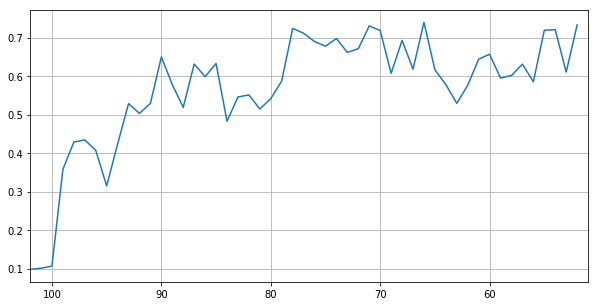

In [82]:
plt.figure(figsize=(10,5))
x = range(trainVal_data.shape[1],len(surv_feature),-1)
plt.plot(x, acc)
plt.xlim(trainVal_data.shape[1], len(surv_feature))
#range(trainVal_data.shape[1],len(surv_feature),-1)
plt.xlabel("")
plt.grid()

In [73]:
acc

[0.09799842559913774,
 0.10118422846576454,
 0.10675588212230948,
 0.3578045637546183,
 0.42871972936785474,
 0.4344407716031294,
 0.40735678723037877,
 0.3149620396649444,
 0.4234442793652079,
 0.5285179535535334,
 0.5033563809044974,
 0.529257905151419,
 0.6501229276800635,
 0.5778064746455581,
 0.5189102008546668,
 0.6313167233045371,
 0.598637972280999,
 0.6329146949513154,
 0.4827892786891847,
 0.5459299985792916,
 0.5510831525313181,
 0.5146098504389461,
 0.5414997757717673,
 0.5876058957695781,
 0.7239666935480839,
 0.7114154320105924,
 0.6897679521112138,
 0.6777023147281463,
 0.6976351749292563,
 0.6616408237821788,
 0.6711709613776295,
 0.7304576653257334,
 0.7184425210454861,
 0.607138026255972,
 0.6928778357069496,
 0.6179849478785793,
 0.7396443051973854,
 0.61667434904054,
 0.5779917778616999,
 0.5293469944396975,
 0.5763175583851204,
 0.6439721543494762,
 0.6569083004537558,
 0.5949857398911372,
 0.6017128016375768,
 0.6310190008440479,
 0.5854352721912811,
 0.7192331074

In [61]:
pred_features.columns[surv_feature]

Index(['population', 'racepctblack', 'racePctWhite', 'racePctHisp',
       'agePct12t21', 'agePct16t24', 'numbUrban', 'pctWInvInc', 'pctWSocSec',
       'pctWPubAsst', 'pctWRetire', 'perCapInc', 'whitePerCap', 'blackPerCap',
       'indianPerCap', 'NumUnderPov', 'PctPopUnderPov', 'PctLess9thGrade',
       'PctNotHSGrad', 'PctBSorMore', 'PctUnemployed', 'PctOccupMgmtProf',
       'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 'TotalPctDiv',
       'PersPerFam', 'PctFam2Par', 'PctKids2Par', 'PctYoungKids2Par',
       'PctTeen2Par', 'NumKidsBornNeverMar', 'PctKidsBornNeverMar',
       'PctRecImmig5', 'PctRecImmig8', 'PersPerRentOccHous',
       'PctPersDenseHous', 'PctHousLess3BR', 'HousVacant', 'PctHousOwnOcc',
       'PctVacantBoarded', 'OwnOccLowQuart', 'OwnOccMedVal', 'OwnOccQrange',
       'MedRent', 'MedOwnCostPctInc', 'NumInShelters', 'PctForeignBorn',
       'PctBornSameState', 'PopDens', 'PctUsePubTrans'],
      dtype='object')